# Multi-domain 2-Chain Graph Analysis with I-FCI vs $\Psi$-FCI

Let there be two domains to consider in our following example. For concreteness, let us follow the story of the paper, and say these are two different laboratory settings, where two proteins are sequenced. We wish to discover the cause-and-effect relationship between these two proteins. 

Here, we analyze the 2-chain selection diagram: $X \leftarrow Y \leftarrow S_0^{1,2}$ with two interventional distributions that occur over domains 1 and 2. $S_0^{1,2}$ is an S-node representing a possible difference in mechanism for node Y between domains 1 and 2.

- X is protein 1
- Y is protein 2
- $S_0^{1,2}$ represents a change in laboratory settings that induce changes in the protein 2 expression levels

Experiments are done by perturbing protein 1 (X) and then measuring the protein expression levels of X and Y.

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
from IPython.display import display_svg

In [114]:
from pprint import pprint
import numpy as np
import scipy
import pandas as pd
import collections
from itertools import combinations
import networkx as nx
import pywhy_graphs as pgraphs
from pywhy_graphs.functional import (
    make_graph_linear_gaussian,
    make_graph_multidomain,
    set_node_attributes_with_G,
    apply_linear_soft_intervention,
    sample_multidomain_lin_functions,
)
from pywhy_graphs.viz import draw
from pywhy_graphs.simulate import simulate_random_er_dag

from dodiscover.cd import KernelCDTest
from dodiscover.ci import KernelCITest, FisherZCITest, Oracle
from dodiscover.constraint.skeleton import LearnMultiDomainSkeleton
from dodiscover.constraint.utils import dummy_sample
from dodiscover.datasets import sample_from_graph

from dodiscover import (
    SFCI,
    PsiFCI,
    FCI,
    Context,
    make_context,
    InterventionalContextBuilder,
)
from dodiscover.metrics import structure_hamming_dist, confusion_matrix_networks

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
seed = 12345

In [5]:
alpha = 0.05

## Setup Linear Functional Graph

In [6]:
node_mean_lims = [-1, 1]
node_std_lims = [0.5, 1.5]
edge_functions = [lambda x: x, lambda x: x**2]
edge_weight_lims = [-1, 1]

n_domains = 2
n_samples = 5000

In [7]:
directed_edges = [("y", "x")]

graph = pgraphs.AugmentedGraph(
    incoming_directed_edges=directed_edges,
)

int_graph = graph.copy()
int_graph.add_f_node({"x"}, domain=1)

aug_graph = int_graph.copy()
aug_graph.add_f_node({"x"}, domain=2, require_unique=False)
aug_graph.add_s_node((1, 2), {"y"})

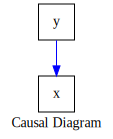

In [8]:
G = draw(graph, name="Causal Diagram")
G.render(
    outfile="./two-chain-single-domain.pdf",
    format="pdf",
    cleanup=True,
)
display_svg(G)

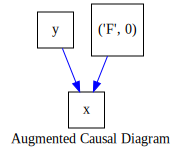

In [9]:
G = draw(int_graph, name="Augmented Causal Diagram")
G.render(
    outfile="./two-chain-single-domain-with-int.pdf",
    format="pdf",
    cleanup=True,
)
display_svg(G)

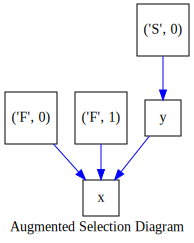

In [10]:
G = draw(aug_graph, name="Augmented Selection Diagram")
G.render(
    outfile="./two-chain-multi-domain-with-int.pdf",
    format="pdf",
    cleanup=True,
)
display_svg(G)

In [11]:
# convert graph to linear functional graph
lin_graph = make_graph_linear_gaussian(
    graph,
    node_mean_lims=node_mean_lims,
    node_std_lims=node_std_lims,
    edge_functions=edge_functions,
    edge_weight_lims=edge_weight_lims,
    random_state=seed,
)

In [12]:
# convert graph to linear functional graph
lin_graph = make_graph_linear_gaussian(
    graph,
    node_mean_lims=node_mean_lims,
    node_std_lims=node_std_lims,
    edge_functions=edge_functions,
    edge_weight_lims=edge_weight_lims,
    random_state=seed,
)

In [13]:
# convert graph to linear functional graph
aug_lin_graph = make_graph_linear_gaussian(
    aug_graph,
    node_mean_lims=node_mean_lims,
    node_std_lims=node_std_lims,
    edge_functions=edge_functions,
    edge_weight_lims=edge_weight_lims,
    random_state=seed,
)
md_lin_graph = sample_multidomain_lin_functions(
    aug_lin_graph,
    n_domains=n_domains,
    node_mean_lims=node_mean_lims,
    node_std_lims=node_std_lims,
    edge_functions=edge_functions,
    edge_weight_lims=edge_weight_lims,
    random_state=seed,
)

In [14]:
for node in aug_lin_graph.nodes(data=True):
    pprint(node)

('y',
 {'gaussian_noise_function': {'mean': 0.19661750717437965,
                              'std': 0.6867341856037134},
  'parent_functions': {('S', 0): {'func': <function <lambda> at 0x148caa8b0>,
                                  'weight': -0.5453279550656607}}})
('x',
 {'gaussian_noise_function': {'mean': 0.3455120880292426,
                              'std': 1.441802865269937},
  'parent_functions': {'y': {'func': <function <lambda> at 0x148caa8b0>,
                             'weight': -0.5453279550656607},
                       ('F', 0): {'func': <function <lambda> at 0x148caa940>,
                                  'weight': 0.5947309146654682},
                       ('F', 1): {'func': <function <lambda> at 0x148caa8b0>,
                                  'weight': 0.3525093415019491}}})
(('F', 0),
 {'gaussian_noise_function': {'mean': -0.5453279550656607,
                              'std': 0.8167583397097529},
  'parent_functions': {}})
(('F', 1),
 {'gaussian_noise_func

In [15]:
for node in md_lin_graph.nodes(data=True):
    pprint(node)

('y',
 {'domain_gaussian_noise_function': {1: {'mean': -0.5453279550656607,
                                         'std': 0.8167583397097529},
                                     2: {'mean': 0.5947309146654682,
                                         'std': 1.1762546707509745}},
  'gaussian_noise_function': {'mean': 0.19661750717437965,
                              'std': 0.6867341856037134},
  'invariant_domains': set(),
  'parent_functions': {('S', 0): {'func': <function <lambda> at 0x148caa8b0>,
                                  'weight': -0.5453279550656607}}})
('x',
 {'gaussian_noise_function': {'mean': 0.3455120880292426,
                              'std': 1.441802865269937},
  'parent_functions': {'y': {'func': <function <lambda> at 0x148caa8b0>,
                             'weight': -0.5453279550656607},
                       ('F', 0): {'func': <function <lambda> at 0x148caa940>,
                                  'weight': 0.5947309146654682},
                       ('

In [16]:
# example analysis
est = KernelCITest()
est = FisherZCITest()

In [17]:
est.test(data[1], {"x"}, {"y"}, {})

NameError: name 'data' is not defined

In [91]:
x_var = 
# compute conditional independence test
# get the sigma-map for this F-node
distribution_idx = context.sigma_map[x_var]

# get the distributions across the two distributions
data_i = data[distribution_idx[0]].copy()
data_j = data[distribution_idx[1]].copy()

# name the group column the F-node, so Oracle works as expected
data_i[x_var] = 0
data_j[x_var] = 1
this_data = pd.concat((data_i, data_j), axis=0)

SyntaxError: invalid syntax (1201510190.py, line 1)

ERROR:root:Cannot parse: 1:8: x_var = 
Traceback (most recent call last):
  File "/Users/adam2392/miniconda3/envs/pywhy-discover/lib/python3.9/site-packages/lab_black.py", line 218, in format_cell
    formatted_code = _format_code(cell)
  File "/Users/adam2392/miniconda3/envs/pywhy-discover/lib/python3.9/site-packages/lab_black.py", line 29, in _format_code
    return format_str(src_contents=code, mode=FileMode())
  File "/Users/adam2392/miniconda3/envs/pywhy-discover/lib/python3.9/site-packages/black/__init__.py", line 1073, in format_str
    dst_contents = _format_str_once(src_contents, mode=mode)
  File "/Users/adam2392/miniconda3/envs/pywhy-discover/lib/python3.9/site-packages/black/__init__.py", line 1083, in _format_str_once
    src_node = lib2to3_parse(src_contents.lstrip(), mode.target_versions)
  File "/Users/adam2392/miniconda3/envs/pywhy-discover/lib/python3.9/site-packages/black/parsing.py", line 127, in lib2to3_parse
    raise exc from None
black.parsing.InvalidInput: Cann

## Sample Dataset

In [18]:
n_samples = 5000

In [34]:
print(lin_graph.augmented_nodes)
print(md_lin_graph.non_augmented_nodes)
print(md_lin_graph.edges())
print(list(nx.topological_sort(md_lin_graph.get_graphs("directed"))))

[('F', 0), ('F', 1), ('S', 0)]
{'x', 'y'}
{'directed': OutEdgeView([('y', 'x'), (('F', 0), 'x'), (('F', 1), 'x'), (('S', 0), 'y')]), 'bidirected': EdgeView([]), 'undirected': EdgeView([])}
[('F', 0), ('F', 1), ('S', 0), 'y', 'x']


In [37]:
domain_indices = []
intervention_targets = []
mechanisms = []
data = []

for idx, domain_id in enumerate(range(1, n_domains + 1)):
    df = sample_from_graph(
        md_lin_graph,
        sample_func="multidomain",
        n_samples=n_samples,
        n_jobs=1,
        random_state=seed,
        domain_id=domain_id,
    )

    domain_indices.append(domain_id)
    intervention_targets.append({"x"})
    mechanisms.append(idx)
    data.append(df)

# Oracle Analysis

First, we compare what would happen with the oracle graph, when we learn using the ground-truth augmented selection diagram.

We compare the FCI, $\Psi$-FCI and S-FCI algorithms

In [38]:
context = make_context().variables(aug_graph.non_augmented_nodes).build()

In [16]:
oracle = Oracle(graph)
dummy_df = dummy_sample(graph)
print(graph.nodes)

['x', 'y']


In [17]:
# now learn the relationships
oracle_learner = FCI(ci_estimator=oracle, alpha=alpha)
oracle_learner.fit(
    dummy_df,
    context,
)

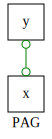

In [18]:
fci_oracle_g = draw(oracle_learner.graph_, name="PAG")
fci_oracle_g.render(
    filename="./two-chain-fci-oracle",
    outfile="./two-chain-fci-oracle.pdf",
    format="pdf",
    cleanup=True,
)
display_svg(fci_oracle_g)

In [76]:
context = (
    make_context(create_using=InterventionalContextBuilder)
    .variables(aug_graph.non_augmented_nodes)
    .obs_distribution(False)
    .intervention_targets([("x"), ()])
    .num_distributions(2)
    .build()
)

In [77]:
# IFCI
oracle_learner = PsiFCI(
    ci_estimator=oracle,
    cd_estimator=oracle,
    alpha=alpha,
    known_intervention_targets=True,
)
oracle_learner.fit(
    [dummy_df, dummy_df],
    context,
)

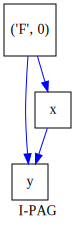

In [78]:
ifci_oracle_g = draw(oracle_learner.graph_, name="I-PAG")
ifci_oracle_g.render(
    filename="./two-chain-ifci-oracle",
    outfile="./two-chain-ifci-oracle.pdf",
    format="pdf",
    cleanup=True,
)
display_svg(ifci_oracle_g)

In [29]:
# SFCI
oracle_learner = SFCI(ci_estimator=oracle, cd_estimator=oracle, alpha=alpha)
oracle_learner.fit(
    [dummy_df, dummy_df],
    context,
    domain_indices=domain_indices,
    intervention_targets=intervention_targets,
    # debug=False
)

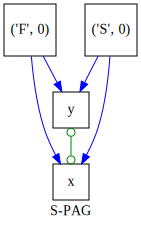

In [30]:
sfci_oracle_g = draw(oracle_learner.graph_, name="S-PAG")
sfci_oracle_g.render(
    filename="./two-chain-sfci-oracle",
    outfile="./two-chain-sfci-oracle.pdf",
    format="pdf",
    cleanup=True,
)
display_svg(sfci_oracle_g)

# Generated Data Analysis

## With FCI

In [44]:
context = make_context().variables(aug_graph.non_augmented_nodes).build()

In [45]:
# now learn the relationships
learner = FCI(ci_estimator=FisherZCITest(), alpha=alpha)
learner.fit(
    pd.concat(data, axis=0),
    context,
)

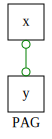

In [46]:
fci_g = draw(learner.graph_, name="PAG")
fci_g.render(
    filename="./two-chain-fci",
    outfile="./two-chain-fci.pdf",
    format="pdf",
    cleanup=True,
)
display_svg(fci_g)

## With I-FCI

In [56]:
context = (
    make_context(create_using=InterventionalContextBuilder)
    .variables(aug_graph.non_augmented_nodes)
    .obs_distribution(False)
    .intervention_targets([("x"), ("x")])
    .mechanisms([{"x": 1}, {"x": 2}])
    .num_distributions(2)
    .build()
)

In [57]:
# IFCI
learner = PsiFCI(
    ci_estimator=FisherZCITest(),
    cd_estimator=KernelCDTest(),
    alpha=alpha,
    known_intervention_targets=True,
)
learner.fit(
    data,
    context,
)

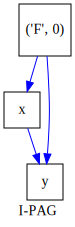

In [58]:
ifci_g = draw(learner.graph_, name="I-PAG")
ifci_g.render(
    filename="./two-chain-ifci-oracle",
    outfile="./two-chain-ifci-oracle.pdf",
    format="pdf",
    cleanup=True,
)
display_svg(ifci_g)

## Correct Answer with S-FCI

In [39]:
context = (
    make_context(create_using=InterventionalContextBuilder)
    .variables(aug_graph.non_augmented_nodes)
    .num_distributions(2)
    .build()
)

In [40]:
# now learn the relationships
learner = SFCI(
    ci_estimator=FisherZCITest(), cd_estimator=KernelCDTest(), alpha=alpha, debug=True
)

In [41]:
learner.fit(
    data,
    context,
    domain_indices=domain_indices,
    intervention_targets=intervention_targets,
)

Comparing x-y | set() : 0.0
Trying to learn skeleton for 1 and 2 to remove F-nodes: [('F', 0)] grouped with S-node: ('S', 0)
Comparing {('S', 0), ('F', 0)}-x | set() : 0.0
Comparing {('S', 0), ('F', 0)}-y | set() : 0.0
Comparing {('S', 0), ('F', 0)}-x | {'y'} : 0.0
Comparing {('S', 0), ('F', 0)}-y | {'x'} : 0.0
[('F', 0)]
[]
{('F', 0): frozenset()}
{('F', 0): [0, 1]}
Trying to learn skeleton for 1 to remove F-nodes: []
Trying to learn skeleton for 2 to remove F-nodes: []


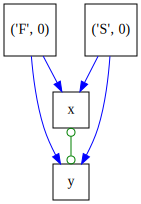

In [42]:
draw(learner.graph_)

In [43]:
pprint(learner.separating_sets_)

defaultdict(<function BaseConstraintDiscovery._initialize_sep_sets.<locals>.<lambda> at 0x148d275e0>,
            {('S', 0): defaultdict(<class 'list'>, {('F', 0): []})})


In [106]:
rng = np.random.default_rng(seed)
test = rng.dirichlet((10, 2), 20)
print(test)
print(test.mean(axis=0))

print(10 / 12)
print(2 / 12)

[[0.88338169 0.11661831]
 [0.95437093 0.04562907]
 [0.92598123 0.07401877]
 [0.74032007 0.25967993]
 [0.74200266 0.25799734]
 [0.89661462 0.10338538]
 [0.54642251 0.45357749]
 [0.94539668 0.05460332]
 [0.67546416 0.32453584]
 [0.75045264 0.24954736]
 [0.89957344 0.10042656]
 [0.85249165 0.14750835]
 [0.81894958 0.18105042]
 [0.84897506 0.15102494]
 [0.86968602 0.13031398]
 [0.96352565 0.03647435]
 [0.81842388 0.18157612]
 [0.80927313 0.19072687]
 [0.58526745 0.41473255]
 [0.84046682 0.15953318]]
[0.81835199 0.18164801]
0.8333333333333334
0.16666666666666666


In [120]:
def convert_md_data_to_sd(data, domain_indices, intervention_targets):
    # generate single-domain data
    single_domain_data = []
    single_domain_targets = []

    seen_indices = set()
    for targets in intervention_targets:
        indices = [
            idx
            for idx in range(len(domain_indices))
            if intervention_targets[idx] == targets
        ]
        if any(idx in seen_indices for idx in indices):
            continue
        for idx in indices:
            seen_indices.add(idx)

        single_domain_data.append(pd.concat([data[idx] for idx in indices], axis=0))
        if targets == {}:
            continue
        single_domain_targets.append(targets)
    return single_domain_data, single_domain_targets

# Large-scale random graph analysis

Now, we instantiate a large number of functions over the two-chain graph setup we have to determine if this is just a function of the specific data setup we have. We demonstrate that in fact, consistently, I-FCI gets the wrong answer as is shown in the oracle setting across any function, noise parametrization, weight, or number of samples in our parameter grid.

Our metric that we measure the performance of the algorithsm is the 1-0 loss. It is 0 if the Y->X is oriented as X o-o Y, or correctly and 1 otherwise.

In [118]:
node_mean_lims = [-5, 5]
node_std_lims = [0.01, 1.5]
edge_functions = [lambda x: x, lambda x: x**2, lambda x: np.sin(x), lambda x: -x]
edge_weight_lims = [-5, 5]
n_node_grid = np.arange(5, 15)
p_grid = np.linspace(0.1, 0.4, 5)
n_domains_grid = np.arange(2, 10)
n_repeats = 5

n_samples = 1000
ratio_interventions = 0.2

print(n_node_grid)
print(p_grid)

[ 5  6  7  8  9 10 11 12 13 14]
[0.1   0.175 0.25  0.325 0.4  ]


KeyboardInterrupt: 

In [90]:
res_df = pd.DataFrame(sfci_results)
res_df["alg"] = "sfci"
temp_df = pd.DataFrame(ifci_results)
temp_df["alg"] = "ifci"
res_df = pd.concat((res_df, temp_df), axis=0)
res_df = res_df.reset_index()

res_df = pd.melt(
    res_df,
    id_vars="alg",
    var_name="n_samples",
    value_vars=n_sample_grid,
    value_name="loss",
)

display(res_df)

,alg,n_samples,loss
0,sfci,50.0,0
1,sfci,50.0,0
2,sfci,50.0,0
3,sfci,50.0,0
4,sfci,50.0,0
...,...,...,...
95,ifci,5000.0,1
96,ifci,5000.0,1
97,ifci,5000.0,1
98,ifci,5000.0,1


In [94]:
res_df.columns = ["Alg.", "# Samples", "Loss"]

<Axes: xlabel='# Samples', ylabel='Loss'>

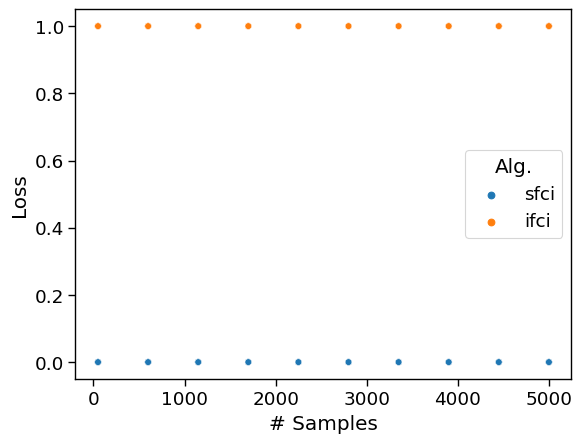

In [96]:
sns.set_context("paper", font_scale=1.5)
sns.scatterplot(data=res_df, x="# Samples", y="Loss", hue="Alg.")